# Decision-Focused Learning for Portfolio Optimization
## Tutorial: DFL for Mean-Variance Optimization

This tutorial demonstrates how to implement Decision-Focused Learning (DFL) for portfolio optimization using Mean-Variance Optimization (MVO).   
This code is a simplified version written for educational purposes. For research or production use, more detailed and sophisticated modifications are required.

### Key Concepts:

**Decision-Focused Learning (DFL)** is a machine learning approach that trains models by directly optimizing for the downstream decision-making task, rather than just prediction accuracy.

**Traditional Two-Stage Approach:**
1. Train a model to predict returns (minimize prediction error)
2. Use predictions in optimization to make decisions

**DFL Approach:**
1. Train the model by optimizing the quality of decisions made using its predictions
2. Backpropagate through the optimization layer to improve decision quality

### What You'll Learn:
1. How to build a differentiable portfolio optimization layer
2. How to combine prediction loss with decision loss
3. How to train end-to-end through optimization problems
4. Comparing Two-Stage (alpha=0.0) vs. DFL (alpha=0.5)

## 1. Import Libraries and Setup

In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import yfinance as yf
from datetime import datetime, timedelta
import cvxpy as cp
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, List, Dict
import warnings
import copy

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Libraries imported successfully")

Libraries imported successfully


## 2. Define Dataset Class

Create a dataset class to handle stock return data with rolling windows.

In [20]:
class StockDataset(Dataset):
    """Dataset class for stock returns with rolling windows"""
    
    def __init__(self, returns_data: pd.DataFrame, lookback_window: int = 60, 
                 prediction_horizon: int = 1):
        self.returns = returns_data.values
        self.dates = returns_data.index
        self.stock_names = returns_data.columns
        self.lookback_window = lookback_window
        self.prediction_horizon = prediction_horizon
        self.n_stocks = len(self.stock_names)
        self.valid_indices = list(range(lookback_window, 
                                       len(self.returns) - prediction_horizon))
        
    def __len__(self):
        return len(self.valid_indices)
    
    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        X = self.returns[actual_idx - self.lookback_window:actual_idx]
        y = self.returns[actual_idx:actual_idx + self.prediction_horizon].mean(axis=0)
        cov_matrix = np.cov(X.T)
        return (torch.FloatTensor(X), 
                torch.FloatTensor(y), 
                torch.FloatTensor(cov_matrix))

print("Dataset class defined")

Dataset class defined


## 3. Define Model Architecture

### 3.1 Return Prediction Neural Network

In [21]:
class ReturnPredictor(nn.Module):
    """Neural network for predicting stock returns"""
    
    def __init__(self, lookback_window: int, n_stocks: int, hidden_dims: List[int] = [128, 64, 32]):
        super(ReturnPredictor, self).__init__()
        input_dim = lookback_window * n_stocks
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.BatchNorm1d(hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.2)
            ])
            prev_dim = hidden_dim
        
        layers.append(nn.Linear(prev_dim, n_stocks))
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        return self.network(x)

print("ReturnPredictor defined")

ReturnPredictor defined


### 3.2 Differentiable MVO Optimization Layer

The key innovation in DFL is making the optimization layer differentiable. This allows gradients to flow from the decision quality back to the prediction model.

We use **cvxpylayers** to create a differentiable convex optimization layer that solves:
- Maximize: portfolio_return - lambda * portfolio_variance
- Subject to: weights sum to 1, weights >= 0

In [ ]:
class MVOOptimizationLayer(nn.Module):
    """Differentiable MVO layer using cvxpylayers"""
    
    def __init__(self, n_stocks: int, lambda_risk: float = 1.0):
        super(MVOOptimizationLayer, self).__init__()
        self.n_stocks = n_stocks
        self.lambda_risk = lambda_risk
        
        # Define optimization problem
        mu = cp.Parameter(n_stocks)
        L = cp.Parameter((n_stocks, n_stocks))
        w = cp.Variable(n_stocks)
        
        portfolio_variance = cp.sum_squares(L.T @ w)
        objective = cp.Maximize(mu @ w - self.lambda_risk * portfolio_variance)
        
        constraints = [cp.sum(w) == 1, w >= 0]
        
        problem = cp.Problem(objective, constraints)
        self.optimization_layer = CvxpyLayer(problem, parameters=[mu, L], variables=[w])
        
    def forward(self, predicted_returns, covariance_matrices):
        batch_size = predicted_returns.shape[0]
        weights_list = []
        
        for i in range(batch_size):
            cov = covariance_matrices[i] + torch.eye(self.n_stocks, device=covariance_matrices.device) * 1e-6
            L = torch.linalg.cholesky(cov)
            # cvxpylayers requires CPU tensors
            weights, = self.optimization_layer(predicted_returns[i].cpu(), L.cpu())
            weights_list.append(weights.to(predicted_returns.device))
        
        return torch.stack(weights_list)

print("MVOOptimizationLayer defined")

MVOOptimizationLayer defined


## 4. Define Loss Function

The DFL loss function is the core of Decision-Focused Learning. It combines two objectives:

**1. Prediction Loss (MSE):** Traditional loss that measures prediction accuracy
- Measures how well we predict returns
- `L_pred = MSE(predicted_returns, true_returns)`

**2. Decision Loss (MVO):** Novel loss that measures decision quality
- Measures the quality of portfolios created using our predictions
- `L_decision = objective(optimal_weights) - objective(predicted_weights)`
- Lower when our predictions lead to better portfolio decisions

**Combined Loss:** `L = alpha * L_decision + (1 - alpha) * L_pred`
- alpha = 0.0: Pure two-stage (only prediction accuracy)
- alpha = 0.5: Hybrid approach (50% decision quality, 50% prediction accuracy)

In [23]:
class DFLLoss(nn.Module):
    """Combined loss function for Decision-Focused Learning"""
    
    def __init__(self, lambda_risk: float = 1.0, alpha: float = 0.5):
        super(DFLLoss, self).__init__()
        self.lambda_risk = lambda_risk
        self.alpha = alpha
        self.mse_loss = nn.MSELoss()
        
    def compute_mvo_objective(self, weights, returns, covariance):
        batch_size = weights.shape[0]
        objectives = []
        
        for i in range(batch_size):
            w = weights[i]
            mu = returns[i]
            cov = covariance[i]
            portfolio_return = torch.dot(w, mu)
            portfolio_variance = torch.dot(w, torch.matmul(cov, w))
            objective = portfolio_return - self.lambda_risk * portfolio_variance
            objectives.append(objective)
        
        return torch.stack(objectives)
    
    def forward(self, predicted_returns, true_returns, predicted_weights, 
                true_weights, covariance_matrices):
        mse_loss = self.mse_loss(predicted_returns, true_returns)
        predicted_objective = self.compute_mvo_objective(predicted_weights, 
                                                        true_returns, 
                                                        covariance_matrices)
        optimal_objective = self.compute_mvo_objective(true_weights, 
                                                      true_returns, 
                                                      covariance_matrices)
        mvo_loss = torch.mean(optimal_objective - predicted_objective)
        combined_loss = self.alpha * mvo_loss + (1 - self.alpha) * mse_loss
        return combined_loss, mse_loss, mvo_loss

print("DFLLoss defined")

DFLLoss defined


## 5. Implement Early Stopping

Stop training early when validation loss stops improving.

In [24]:
class EarlyStopping:
    """Early stopping implementation"""
    
    def __init__(self, patience=5, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.delta = delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.best_model = None
        
    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'    EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'    Validation loss decreased ({self.val_loss_min:.6f} → {val_loss:.6f}). Saving model...')
        self.best_model = copy.deepcopy(model.state_dict())
        self.val_loss_min = val_loss

print("EarlyStopping class defined")

EarlyStopping class defined


## 6. Training and Validation Functions

Implement training loop with early stopping (without storing loss history).

In [ ]:
def validate_model(model, mvo_layer, dataloader, loss_fn, device='cpu'):
    """Validate the model"""
    model.eval()
    total_loss = 0
    n_batches = 0
    
    with torch.no_grad():
        for features, targets, cov_matrices in dataloader:
            features, targets, cov_matrices = features.to(device), targets.to(device), cov_matrices.to(device)
            
            predicted_returns = model(features)
            true_weights = mvo_layer(targets, cov_matrices)
            predicted_weights = mvo_layer(predicted_returns, cov_matrices)
            
            batch_total_loss, _, _ = loss_fn(
                predicted_returns, targets, predicted_weights, true_weights, cov_matrices
            )
            
            total_loss += batch_total_loss.item()
            n_batches += 1
    
    return total_loss / n_batches


def train_model_with_early_stopping(model, mvo_layer, train_loader, val_loader, 
                                   loss_fn, optimizer, epochs=100, patience=5, device='cpu'):
    """Train model with early stopping"""
    model.to(device)
    
    stopped_epoch = epochs
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(epochs):
        # Training
        model.train()
        epoch_total_loss = 0
        n_batches = 0
        
        for features, targets, cov_matrices in train_loader:
            features, targets, cov_matrices = features.to(device), targets.to(device), cov_matrices.to(device)
            
            predicted_returns = model(features)
            
            with torch.no_grad():
                true_weights = mvo_layer(targets, cov_matrices)
            
            predicted_weights = mvo_layer(predicted_returns, cov_matrices)
            total_loss, _, _ = loss_fn(
                predicted_returns, targets, predicted_weights, true_weights, cov_matrices
            )
            
            optimizer.zero_grad()
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            epoch_total_loss += total_loss.item()
            n_batches += 1
        
        avg_train_total = epoch_total_loss / n_batches
        
        # Validation
        val_total = validate_model(model, mvo_layer, val_loader, loss_fn, device)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_total:.6f}, Val Loss: {val_total:.6f}")
        
        # Early stopping check
        early_stopping(val_total, model)
        
        if early_stopping.early_stop:
            print(f"  Early stopping triggered at epoch {epoch + 1}")
            stopped_epoch = epoch + 1
            model.load_state_dict(early_stopping.best_model)
            break
    
    return stopped_epoch

print("Training functions defined")

Training functions defined


## 7. Evaluate Functions

Define functions for data collection and model evaluation.

In [26]:
def fetch_stock_data(tickers: List[str], start_date: str, end_date: str) -> pd.DataFrame:
    """Fetch stock data from Yahoo Finance"""
    print(f"Fetching data for {len(tickers)} stocks...")
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    if len(tickers) == 1:
        prices = data['Close'].to_frame(columns=[tickers[0]])
    else:
        prices = data['Close']
    returns = prices.pct_change().dropna()
    print(f"Data fetched: {returns.shape[0]} days, {returns.shape[1]} stocks")
    return returns


def evaluate_model(model, mvo_layer, dataloader, device='cpu'):
    """Evaluate the model"""
    model.to(device)
    model.eval()
    
    all_predicted_returns = []
    all_true_returns = []
    all_predicted_weights = []
    all_portfolio_returns = []
    
    with torch.no_grad():
        for features, targets, cov_matrices in dataloader:
            features, targets, cov_matrices = features.to(device), targets.to(device), cov_matrices.to(device)
            
            predicted_returns = model(features)
            predicted_weights = mvo_layer(predicted_returns, cov_matrices)
            portfolio_returns = torch.sum(predicted_weights * targets, dim=1)
            
            all_predicted_returns.append(predicted_returns.cpu().numpy())
            all_true_returns.append(targets.cpu().numpy())
            all_predicted_weights.append(predicted_weights.cpu().numpy())
            all_portfolio_returns.append(portfolio_returns.cpu().numpy())
    
    return {
        'predicted_returns': np.concatenate(all_predicted_returns),
        'true_returns': np.concatenate(all_true_returns),
        'predicted_weights': np.concatenate(all_predicted_weights),
        'portfolio_returns': np.concatenate(all_portfolio_returns)
    }

print("Utility functions defined")

Utility functions defined


## 8. Experiment Configuration

Define hyperparameters and settings for the experiment.

In [37]:
print("\n" + "="*60)
print("STARTING DECISION-FOCUSED LEARNING EXPERIMENT")
print("="*60)

# Experiment configuration
config = {
    'tickers': ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 
               'NVDA', 'TSLA', 'JPM', 'V', 'JNJ',
               'WMT', 'PG', 'DIS', 'MA', 'UNH'],  # 15 stocks
    'start_date': '2020-01-01',
    'end_date': '2024-12-31',
    'lookback_window': 60,
    'prediction_horizon': 1,
    'train_split': 0.7,
    'val_split': 0.15,
    'batch_size': 16,
    'epochs': 100,
    'patience': 5,
    'learning_rate': 0.001,
    'lambda_risk': 1.0,
    'alpha_values': [0.0, 0.5],  # Only Two-Stage and Hybrid
    'device': 'cuda' if torch.cuda.is_available() else 'cpu'
}

print("\nConfiguration:")
print(f"  Stocks: {len(config['tickers'])}")
print(f"  Period: {config['start_date']} to {config['end_date']}")
print(f"  Lookback window: {config['lookback_window']} days")
print(f"  Max Epochs: {config['epochs']} (with early stopping, patience={config['patience']})")
print(f"  Alpha values: {config['alpha_values']}")
print(f"    - 0.0: Two-Stage (prediction only)")
print(f"    - 0.5: Hybrid DFL (50% decision quality, 50% prediction)")
print(f"  Device: {config['device']}")


STARTING DECISION-FOCUSED LEARNING EXPERIMENT

Configuration:
  Stocks: 15
  Period: 2020-01-01 to 2024-12-31
  Lookback window: 60 days
  Max Epochs: 100 (with early stopping, patience=5)
  Alpha values: [0.0, 0.5]
    - 0.0: Two-Stage (prediction only)
    - 0.5: Hybrid DFL (50% decision quality, 50% prediction)
  Device: cuda


## 9. Data Preparation

Fetch stock data and split into train/validation/test sets.

In [28]:
# Fetch data
returns_data = fetch_stock_data(config['tickers'], config['start_date'], config['end_date'])

# Create dataset
dataset = StockDataset(returns_data, 
                      lookback_window=config['lookback_window'],
                      prediction_horizon=config['prediction_horizon'])

# Split data into train/val/test
total_size = len(dataset)
train_size = int(total_size * config['train_split'])
val_size = int(total_size * config['val_split'])
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size, test_size]
)

print(f"Dataset splits: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

Fetching data for 15 stocks...
Data fetched: 1256 days, 15 stocks
Dataset splits: 836 train, 179 val, 180 test


## 10. Model Training

Train models with different alpha values and compare performance.

In [29]:
# Store results
all_results = {}
comparison_metrics = []

# Train models with different alpha values
for alpha in config['alpha_values']:
    print(f"\n{'='*50}")
    print(f"Training with alpha = {alpha}")
    print(f"{'='*50}")
    
    # Initialize model
    model = ReturnPredictor(
        lookback_window=config['lookback_window'],
        n_stocks=len(config['tickers']),
        hidden_dims=[256, 128, 64]
    )
    
    mvo_layer = MVOOptimizationLayer(
        n_stocks=len(config['tickers']),
        lambda_risk=config['lambda_risk']
    )
    
    loss_fn = DFLLoss(lambda_risk=config['lambda_risk'], alpha=alpha)
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    
    # Train
    print("Training model...")
    stopped_epoch = train_model_with_early_stopping(
        model=model,
        mvo_layer=mvo_layer,
        train_loader=train_loader,
        val_loader=val_loader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epochs=config['epochs'],
        patience=config['patience'],
        device=config['device']
    )
    
    # Evaluate on test set
    print("Evaluating on test set...")
    results = evaluate_model(
        model=model,
        mvo_layer=mvo_layer,
        dataloader=test_loader,
        device=config['device']
    )
    
    # Store results
    all_results[alpha] = {'results': results, 'stopped_epoch': stopped_epoch}
    
    # Calculate metrics
    portfolio_returns = results['portfolio_returns']
    sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std() * np.sqrt(252)
    
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = np.maximum.accumulate(cumulative)
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = np.min(drawdown) if len(drawdown) > 0 else 0
    
    metrics = {
        'Alpha': alpha,
        'Mean Return': portfolio_returns.mean(),
        'Volatility': portfolio_returns.std(),
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Stopped Epoch': stopped_epoch
    }
    comparison_metrics.append(metrics)
    
    print(f"Results for alpha={alpha}:")
    print(f"  Sharpe Ratio: {sharpe_ratio:.4f}")
    print(f"  Mean Return: {portfolio_returns.mean():.6f}")
    print(f"  Volatility: {portfolio_returns.std():.6f}")
    print(f"  Stopped at epoch: {stopped_epoch}")


Training with alpha = 0.0
Training model...
    Validation loss decreased (inf → 0.008562). Saving model...
    Validation loss decreased (0.008562 → 0.007469). Saving model...
    Validation loss decreased (0.007469 → 0.003910). Saving model...
    Validation loss decreased (0.003910 → 0.002179). Saving model...
    Validation loss decreased (0.002179 → 0.001734). Saving model...
    Validation loss decreased (0.001734 → 0.001139). Saving model...
    Validation loss decreased (0.001139 → 0.000838). Saving model...
    Validation loss decreased (0.000838 → 0.000774). Saving model...
    Validation loss decreased (0.000774 → 0.000672). Saving model...
  Epoch [10/100] - Train Loss: 0.001019, Val Loss: 0.000610
    Validation loss decreased (0.000672 → 0.000610). Saving model...
    Validation loss decreased (0.000610 → 0.000591). Saving model...
    Validation loss decreased (0.000591 → 0.000560). Saving model...
    Validation loss decreased (0.000560 → 0.000536). Saving model...
   

## 11. Results Visualization

Visualize the performance comparison and portfolio selection differences between alpha=0.0 and alpha=0.5.


GENERATING VISUALIZATIONS


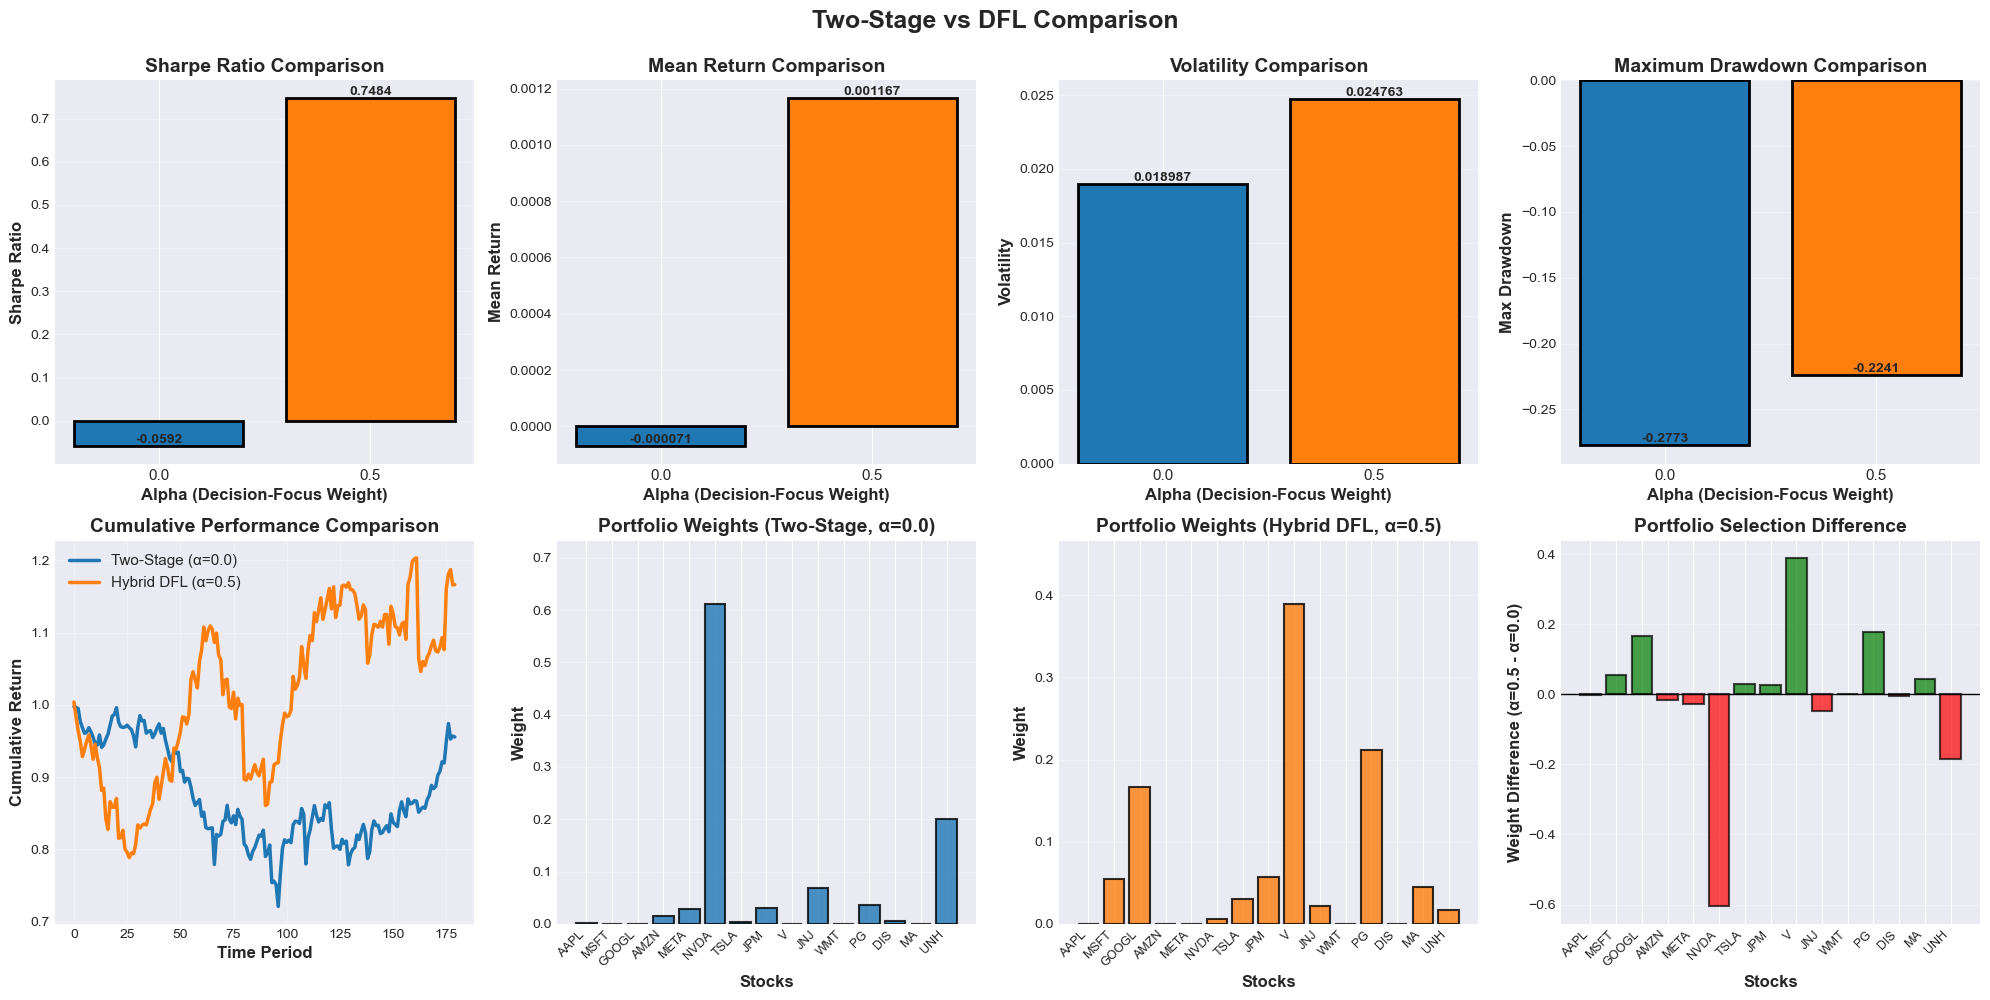

In [ ]:
print("\n" + "="*60)
print("GENERATING VISUALIZATIONS")
print("="*60)

comparison_df = pd.DataFrame(comparison_metrics)

fig = plt.figure(figsize=(20, 10))

# 1. Sharpe Ratio Comparison
plt.subplot(2, 4, 1)
colors = ['#1f77b4', '#ff7f0e']
bars = plt.bar(comparison_df['Alpha'].astype(str), comparison_df['Sharpe Ratio'], 
               color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Alpha (Decision-Focus Weight)', fontsize=12, fontweight='bold')
plt.ylabel('Sharpe Ratio', fontsize=12, fontweight='bold')
plt.title('Sharpe Ratio Comparison', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 2. Mean Return Comparison
plt.subplot(2, 4, 2)
bars = plt.bar(comparison_df['Alpha'].astype(str), comparison_df['Mean Return'], 
               color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Alpha (Decision-Focus Weight)', fontsize=12, fontweight='bold')
plt.ylabel('Mean Return', fontsize=12, fontweight='bold')
plt.title('Mean Return Comparison', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.6f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 3. Volatility Comparison
plt.subplot(2, 4, 3)
bars = plt.bar(comparison_df['Alpha'].astype(str), comparison_df['Volatility'], 
               color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Alpha (Decision-Focus Weight)', fontsize=12, fontweight='bold')
plt.ylabel('Volatility', fontsize=12, fontweight='bold')
plt.title('Volatility Comparison', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.6f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 4. Max Drawdown Comparison
plt.subplot(2, 4, 4)
bars = plt.bar(comparison_df['Alpha'].astype(str), comparison_df['Max Drawdown'], 
               color=colors, edgecolor='black', linewidth=2)
plt.xlabel('Alpha (Decision-Focus Weight)', fontsize=12, fontweight='bold')
plt.ylabel('Max Drawdown', fontsize=12, fontweight='bold')
plt.title('Maximum Drawdown Comparison', fontsize=14, fontweight='bold')
plt.xticks(fontsize=11)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')

# 5. Cumulative Returns Comparison
plt.subplot(2, 4, 5)
for alpha, color in zip([0.0, 0.5], colors):
    returns = all_results[alpha]['results']['portfolio_returns']
    cumulative = (1 + returns).cumprod()
    label = f'Two-Stage (α=0.0)' if alpha == 0.0 else f'DFL (α=0.5)'
    plt.plot(cumulative, label=label, linewidth=2.5, color=color)
plt.xlabel('Time Period', fontsize=12, fontweight='bold')
plt.ylabel('Cumulative Return', fontsize=12, fontweight='bold')
plt.title('Cumulative Performance Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)

# 6. Portfolio Weights Comparison - Alpha=0.0
plt.subplot(2, 4, 6)
avg_weights_0 = all_results[0.0]['results']['predicted_weights'].mean(axis=0)
bars = plt.bar(range(len(config['tickers'])), avg_weights_0, color='#1f77b4', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
plt.xlabel('Stocks', fontsize=12, fontweight='bold')
plt.ylabel('Weight', fontsize=12, fontweight='bold')
plt.title('Portfolio Weights (Two-Stage, α=0.0)', fontsize=14, fontweight='bold')
plt.xticks(range(len(config['tickers'])), config['tickers'], rotation=45, ha='right', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, max(avg_weights_0) * 1.2])

# 7. Portfolio Weights Comparison - Alpha=0.5
plt.subplot(2, 4, 7)
avg_weights_025 = all_results[0.5]['results']['predicted_weights'].mean(axis=0)
bars = plt.bar(range(len(config['tickers'])), avg_weights_025, color='#ff7f0e', 
               edgecolor='black', linewidth=1.5, alpha=0.8)
plt.xlabel('Stocks', fontsize=12, fontweight='bold')
plt.ylabel('Weight', fontsize=12, fontweight='bold')
plt.title('Portfolio Weights (DFL, α=0.5)', fontsize=14, fontweight='bold')
plt.xticks(range(len(config['tickers'])), config['tickers'], rotation=45, ha='right', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')
plt.ylim([0, max(avg_weights_025) * 1.2])

# 8. Weight Difference Heatmap
plt.subplot(2, 4, 8)
weight_diff = avg_weights_025 - avg_weights_0
colors_diff = ['green' if x > 0 else 'red' for x in weight_diff]
bars = plt.bar(range(len(config['tickers'])), weight_diff, color=colors_diff, 
               edgecolor='black', linewidth=1.5, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)
plt.xlabel('Stocks', fontsize=12, fontweight='bold')
plt.ylabel('Weight Difference (α=0.5 - α=0.0)', fontsize=12, fontweight='bold')
plt.title('Portfolio Selection Difference', fontsize=14, fontweight='bold')
plt.xticks(range(len(config['tickers'])), config['tickers'], rotation=45, ha='right', fontsize=9)
plt.grid(True, alpha=0.3, axis='y')

plt.suptitle('Two-Stage vs DFL Comparison', 
            fontsize=18, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()